In [1]:
# CasADi and CASCLIK things
import casclik as cc
import casadi as cs
from urdf2casadi import converter
import time

# Plotting
from matplotlib import pyplot as plt
import common_plots
import nice_plotting

# Graphs in article
This notebook is used to generated figures for the article. Specifically, it generates the Moe2016: Example 2 graphs, where we use Denavit-Hartenberg parameters with `urd2casadi`, and a trajectory that escapes a box.

In [2]:
urdf_path = "./urdf/ur5.urdf"
links = ["world", 
         "base_link", 
         "base", 
         "shoulder_link", 
         "upper_arm_link", 
         "forearm_link", 
         "wrist_1_link", 
         "wrist_2_link", 
         "wrist_3_link", 
         "tool0"]

fk_dict = converter.from_file(root="base_link", tip="tool0", filename=urdf_path)
link_lengths = [0.,-0.425, -0.392, 0., 0., 0.]
link_twists = [cs.np.pi/2, 0., 0., cs.np.pi/2, -cs.np.pi/2, 0.]
link_offsets = [0.089, 0., 0., 0.109, 0.095, 0.082]
joint_angles = ["s" for i in range(6)]
fk_dict = converter.from_denavit_hartenberg(
    joint_angles=joint_angles,
    link_lengths=link_lengths,
    link_offsets=link_offsets,
    link_twists=link_twists,
    joint_names=fk_dict["joint_names"],
    upper_limits=fk_dict["upper"],
    lower_limits=fk_dict["lower"]
)

In [3]:
fk_dict.keys()

['q',
 'upper',
 'lower',
 'dual_quaternion_fk',
 'joint_names',
 'T_fk',
 'joint_list',
 'quaternion_fk']

In [4]:
# Setup time and robot_var
t = cs.MX.sym("t")
q = cs.MX.sym("q", len(fk_dict["joint_names"]))
dq = cs.MX.sym("dq", len(fk_dict["joint_names"]))
# Functions for end-effector things (casadi functions of q)
T_fk = fk_dict["T_fk"]
p_fk = cs.Function("p_fk", [t, q], [T_fk(q)[:3, 3]])
R_fk = cs.Function("R_fk", [t, q], [T_fk(q)[:3, :3]])

# Manipulability
J_p = cs.jacobian(p_fk(t,q), q)
man = cs.mtimes(J_p,J_p.T)
detman = man[0,0]*man[1,1]*man[2,2]+man[0,1]*man[1,2]*man[2,0]+man[0,2]*man[1,0]*man[2,1]
detman += -man[0,2]*man[1,1]*man[2,0] -man[0,1]*man[1,0]*man[2,2] -man[0,0]*man[1,2]*man[2,1]
manipulability_cost = -detman
for i in range(6):
    manipulability_cost += 1e3*q[i]*q[i]
fmanipulability = cs.Function("fman",[q],[manipulability_cost])

In [5]:
# Check the joint limits from the URDF:
q_max = cs.np.array(fk_dict["upper"])
q_min = cs.np.array(fk_dict["lower"])
print("q_min ",str(q_min))
print("q_max ",str(q_max))

# Define a reasonable max joint speed
max_speed = cs.np.pi/5 # rad/s #cs.inf
print("Max speed: ", max_speed)

# Let's pretend home (where we start) is such that we start in the box.
UR5_home = cs.np.array([-1.5, -1.6447247447521742, 1.4830607057020933, -0.9733457906220311, -0.6578997165707934, 0.0])
UR5_home = cs.np.array([-(50.0/180.0)*cs.np.pi,
                        -(160.0/180.0)*cs.np.pi,
                        -(110.0/180.0)*cs.np.pi,
                        -(90.0/180.0)*cs.np.pi,
                        -(90.0/180.0)*cs.np.pi,
                        0.0])

dt = 0.008

('q_min ', '[-6.28318531 -6.28318531 -3.14159265 -6.28318531 -6.28318531 -6.28318531]')
('q_max ', '[ 6.28318531  6.28318531  3.14159265  6.28318531  6.28318531  6.28318531]')
('Max speed: ', 0.6283185307179586)


In [6]:
# Define the basic system limits
# Uphold the joint constraints
joint_limits_cnstr = cc.SetConstraint(
    label="Joint_Limits",
    expression = q,
    set_min = q_min,
    set_max = q_max)

# Listify the joint limits constraints for pseudoinverse, starting with the lowest
joint_limits_cnstr_list = []
for i in range(q.size()[0]):
    joint_limits_cnstr_list.append(
    cc.SetConstraint(label="limit_q_"+str(i),
                     expression=q[i],
                     set_min = q_min[i],
                     set_max = q_max[i],
                    priority = i))

# Let's have some speed limit
joint_speed_limits_cnstr = cc.VelocitySetConstraint(
    label="Joint_speed_limits",
    expression = q,
    set_min = -cs.vertcat([max_speed]*q.size()[0]),
    set_max = cs.vertcat([max_speed]*q.size()[0]))

In [7]:
# Wall avoidance:
x_min, x_max = 0.1, 0.6#0.1, 0.5#0.2, 0.65#
y_min, y_max = -0.5, 0.4#-0.5, 0.4#-0.5, 0.5#
z_min, z_max = -0.3, 0.25#0., 0.55#0.15, 0.55#

# Desired trajectory
omega=0.1
path_des = cs.vertcat(0.5*cs.sin(omega*t)*cs.sin(omega*t) + 0.2,
                      0.5*cs.cos(omega*t)+0.25*cs.sin(omega*t),
                      0.5*cs.sin(omega*t)*cs.cos(omega*t) + 0.1)#0.4)
fpath_des = cs.Function("fpath_des",[t],[path_des])

In [8]:
# collision avoidance separate
colav_x_cnstr = cc.SetConstraint(
    label="colav_x",
    expression=p_fk(t, q)[0],
    set_min=x_min,
    set_max=x_max,
    priority=len(fk_dict["joint_names"])+2,
    constraint_type="hard",
    gain=5e2
)
colav_y_cnstr = cc.SetConstraint(
    label="colav_y",
    expression=p_fk(t, q)[1],
    set_min=y_min,
    set_max=y_max,
    priority=len(fk_dict["joint_names"])+1,
    constraint_type="hard",
    gain=5e2

)
colav_z_cnstr = cc.SetConstraint(
    label="colav_z",
    expression=p_fk(t, q)[2],
    set_min=z_min,
    set_max=z_max,
    priority=len(fk_dict["joint_names"])+3,
    constraint_type="hard",
    gain=5e2
)
colav_x_cnstr_mpc = cc.SetConstraint(
    label="colav_x",
    expression=p_fk(t, q)[0],
    set_min=x_min,
    set_max=x_max,
    priority=len(fk_dict["joint_names"])+2,
    constraint_type="hard",
    gain=1.
)
colav_y_cnstr_mpc = cc.SetConstraint(
    label="colav_y",
    expression=p_fk(t, q)[1],
    set_min=y_min,
    set_max=y_max,
    priority=len(fk_dict["joint_names"])+1,
    constraint_type="hard",
    gain=1.

)
colav_z_cnstr_mpc = cc.SetConstraint(
    label="colav_z",
    expression=p_fk(t, q)[2],
    set_min=z_min,
    set_max=z_max,
    priority=len(fk_dict["joint_names"])+3,
    constraint_type="hard",
    gain=1.
)
# collision avoidance box
colav_box_cnstr = cc.SetConstraint(
    label="colav_box",
    expression=p_fk(t,q),
    set_min = cs.np.array([x_min,y_min,z_min]),
    set_max = cs.np.array([x_max,y_max,z_max]),
    priority=len(fk_dict["joint_names"])+1,
    constraint_type="hard",
    gain=5e2
)
colav_box_cnstr_mpc = cc.SetConstraint(
    label="colav_box",
    expression=p_fk(t,q),
    set_min = cs.np.array([x_min,y_min,z_min]),
    set_max = cs.np.array([x_max,y_max,z_max]),
    priority=len(fk_dict["joint_names"])+1,
    constraint_type="hard",
    gain=1.
)
# Tracking trajectory
path_cnstr = cc.EqualityConstraint(
    label="move_point2",
    expression=p_fk(t, q) - path_des,
    priority=len(fk_dict["joint_names"])+4,
    constraint_type="soft",
    gain=0.15
)

path_cnstr.eval = cs.Function("path_eval", [t,q], [cs.norm_2(path_cnstr.expression)])
# List constraints
constraints = [colav_x_cnstr,
               colav_y_cnstr,
               colav_z_cnstr,
               path_cnstr]# + joint_limits_cnstr_list
constraints_mpc = [colav_x_cnstr_mpc,
                   colav_y_cnstr_mpc,
                   colav_z_cnstr_mpc,
                   path_cnstr]# + joint_limits_cnstr_list

# Setup the skill and print info
skill = cc.SkillSpecification(
    label="box_move",
    time_var=t,
    robot_var=q,
    robot_vel_var=dq,
    constraints=constraints
)
skill_mpc = cc.SkillSpecification(
    label="box_move",
    time_var=t,
    robot_var=q,
    robot_vel_var=dq,
    constraints=constraints_mpc
)
skill_multidim = cc.SkillSpecification(
    label="box_move_multidim",
    time_var=t,
    robot_var=q,
    robot_vel_var=dq,
    constraints=[colav_box_cnstr, path_cnstr]#+joint_limits_cnstr_list
)
skill_multidim_mpc = cc.SkillSpecification(
    label="box_move_multidim",
    time_var=t,
    robot_var=q,
    robot_vel_var=dq,
    constraints=[colav_box_cnstr_mpc, path_cnstr]#+joint_limits_cnstr_list
)
skill.print_constraints()
skill_multidim.print_constraints()

SkillSpecification: box_move
#0: colav_y
#1: colav_x
#2: colav_z
#3: move_point2
Has virtual var: False
Has input var: False
N constraints: 4
N equality:
	Pos:1	Vel:0
N set:
	Pos:3	Vel:0
SkillSpecification: box_move_multidim
#0: colav_box
#1: move_point2
Has virtual var: False
Has input var: False
N constraints: 2
N equality:
	Pos:1	Vel:0
N set:
	Pos:1	Vel:0


In [9]:
# Let's test all the available controllers
controller_classes = {
    "qp":cc.ReactiveQPController, 
    "nlp":cc.ReactiveNLPController, 
    "pinv":cc.PseudoInverseController, 
    "mpc":cc.ModelPredictiveController
}
controllers = {}
for key in controller_classes.keys():
    controllers[key] = {}

In [10]:
skill_situations = {
    "singular":skill,
    "multidim":skill_multidim
}

In [11]:
# Compile all the controllers for each situation
for sitn_key in skill_situations.keys():
    print("Compiling skill: "+str(sitn_key))
    for key in controllers.keys():
        t0 = time.time()
        if key == "pinv" and sitn_key == "multidim":
            controllers[key][sitn_key] = controller_classes[key](skill_spec=skill_situations[sitn_key],
                                                                 options={"multidim_sets":True})
        elif key == "mpc":
            if sitn_key == "singular":
                skill_spec = skill_mpc
            elif sitn_key == "multidim":
                skill_spec = skill_multidim_mpc
            controllers[key][sitn_key] = controller_classes[key](skill_spec=skill_spec,
                                                                 horizon_length=10, timestep=dt)
        elif key == "nlp":
            controllers[key][sitn_key] = controller_classes[key](skill_spec=skill_situations[sitn_key])#,
                                                                 #cost_expr=cs.dot(dq,dq)+manipulability_cost)
        else:
            controllers[key][sitn_key] = controller_classes[key](skill_spec=skill_situations[sitn_key])
        controllers[key][sitn_key].setup_problem_functions()
        controllers[key][sitn_key].setup_solver()
        print("\t-"+str(key)+", compile time: "+str(time.time()-t0))

Compiling skill: multidim
	-qp, compile time: 0.298856973648
	-nlp, compile time: 1.02105116844
	-pinv, compile time: 1.1394071579
	-mpc, compile time: 16.270359993
Compiling skill: singular
	-qp, compile time: 0.440537929535
	-nlp, compile time: 1.36388993263
	-pinv, compile time: 5.75547719002
	-mpc, compile time: 17.315130949


In [12]:
timesteps = 10000
for cntr_key in controllers.keys():
    print("Simulating controller: "+str(cntr_key))
    for sitn_key in skill_situations.keys():
        print("\t-"+str(sitn_key))
        print("\t\tSetting up initial value problem")
        controllers[cntr_key][sitn_key].setup_initial_problem_solver()
        print("\t\tSolving initial value problem")
        slack_res = controllers[cntr_key][sitn_key].solve_initial_problem(0,UR5_home)[-1]
        t0 = time.time()
        # Simulate it!
        t_sim = cs.np.array([dt*i for i in range(timesteps+1)])
        t_run_sim = cs.np.array([dt*i for i in range(timesteps)])
        # Robot
        q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
        q_sim[0,:] = UR5_home
        dq_sim = cs.np.zeros((len(t_sim),q.shape[0]))
        # Cartesian position
        p_sim = cs.np.zeros((len(t_sim), 3))
        p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
        # Rotation
        R_sim = cs.np.zeros((len(t_sim), 3, 3))
        R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
        # Error in tracking
        e_sim = cs.np.zeros(len(t_sim))
        e_sim[0] = path_cnstr.eval(t_sim[0],q_sim[0,:])
        # Controller mode
        mode_sim = cs.np.zeros(len(t_sim))
        # Manipulability
        man_sim = cs.np.zeros(len(t_sim))
        man_sim[0] = fmanipulability(UR5_home)
        # Loop
        for i in range(len(t_sim) - 1):
            t_run0 = time.time()
            res = controllers[cntr_key][sitn_key].solve(t_sim[i],q_sim[i,:],warmstart_slack_var=slack_res)
            t_run_sim[i] = time.time() - t_run0
            dq_sim[i,:] = res[0].toarray()[:,0]
            if res[-1] is not None:
                slack_res = res[-1].toarray()[:,0]
            for idx, dqi in enumerate(dq_sim[i,:]):
                dq_sim[i,idx] = max(min(dqi,max_speed),-max_speed)
            q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
            p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
            R_sim[i+1,:,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()
            e_sim[i+1] = path_cnstr.eval(t_sim[i],q_sim[i+1,:])
            if cntr_key == "pinv":
                mode_sim[i+1] = controllers[cntr_key][sitn_key].current_mode
            man_sim[i+1] = fmanipulability(q_sim[i+1])
        controllers[cntr_key][str(sitn_key)+"_res"] = {
            "t_sim":t_sim,
            "t_run_sim": t_run_sim,
            "dq_sim": dq_sim,
            "q_sim": q_sim,
            "p_sim": p_sim,
            "R_sim": R_sim,
            "e_sim": e_sim,
            "mode_sim": mode_sim,
            "man_sim": man_sim
        }
        print("\t\tRuntime: "+str(time.time()-t0))

Simulating controller: qp
	-multidim
		Setting up initial value problem
		Solving initial value problem
		Runtime: 4.7679169178
	-singular
		Setting up initial value problem
		Solving initial value problem
		Runtime: 4.82172298431
Simulating controller: nlp
	-multidim
		Setting up initial value problem
		Solving initial value problem

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

		Runtime: 34.5347630978
	-singular
		Setting up initial value problem
		Solving initial value problem
		Runtime: 35.7612130642
Simulating controller: pinv
	-multidim
		Setting up initial value problem
		Solving initial value problem
		Runtime: 3.31145405769
	-singular
		Sett

<IPython.core.display.Javascript object>


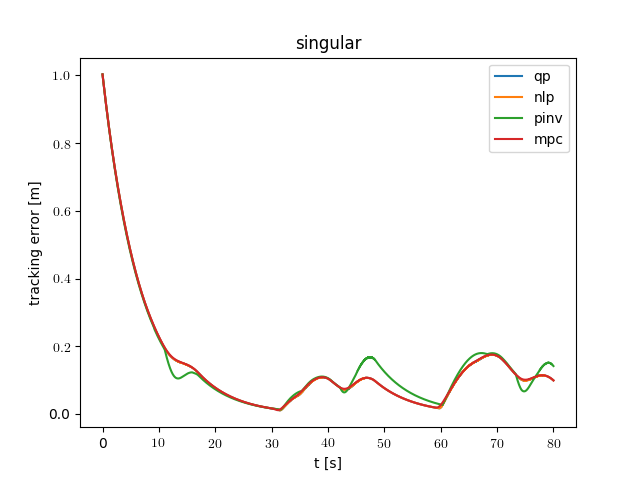

Text(0.5,1,'singular')

In [13]:
%matplotlib notebook

fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["singular_res"]["t_sim"],
            controllers[name]["singular_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("tracking error [m]")
#ax.set_yscale("log")
ax.set_title("singular")

<IPython.core.display.Javascript object>


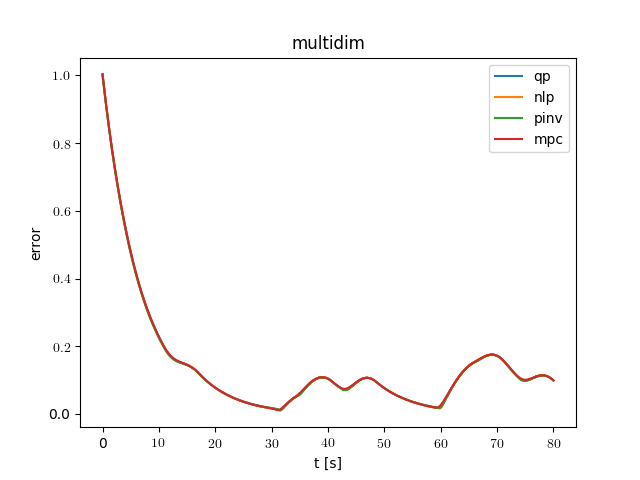

Text(0.5,1,'multidim')

In [14]:
fig, ax = plt.subplots()
for name in controllers.keys():
    ax.plot(controllers[name]["multidim_res"]["t_sim"],
            controllers[name]["multidim_res"]["e_sim"],
            label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("error")
#ax.set_yscale("log")
ax.set_title("multidim")

<IPython.core.display.Javascript object>


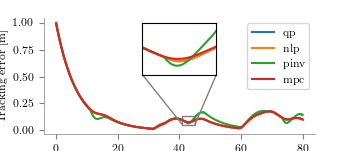

In [15]:
import nice_plotting
nice_plotting.latexify(fig_width=3.5, fig_height=0.7*2.1636)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
fig, ax = plt.subplots()
axins = zoomed_inset_axes(ax, 6, loc=9)
for name in controllers.keys():
    ax.plot(controllers[name]["singular_res"]["t_sim"],
            controllers[name]["singular_res"]["e_sim"],
            label=name)
    axins.plot(controllers[name]["singular_res"]["t_sim"],
               controllers[name]["singular_res"]["e_sim"],
               label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("Tracking error [m]")
axins.set_xlim(41, 45)
axins.set_ylim(0.05,0.13)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
nice_plotting.format_axes(ax)
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
plt.savefig("singular_tracking_error.pdf",bbox_inches="tight")

<IPython.core.display.Javascript object>


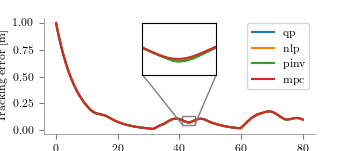

In [16]:
import nice_plotting
nice_plotting.latexify(fig_width=3.5, fig_height=0.7*2.1636)
fig, ax = plt.subplots()
axins = zoomed_inset_axes(ax, 6, loc=9)
for name in controllers.keys():
    ax.plot(controllers[name]["multidim_res"]["t_sim"],
            controllers[name]["multidim_res"]["e_sim"],
            label=name)
    axins.plot(controllers[name]["multidim_res"]["t_sim"],
               controllers[name]["multidim_res"]["e_sim"],
               label=name)
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("Tracking error [m]")
axins.set_xlim(41, 45)
axins.set_ylim(0.05,0.13)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
nice_plotting.format_axes(ax)
plt.savefig("multidim_tracking_error.pdf",bbox_inches="tight")

<IPython.core.display.Javascript object>


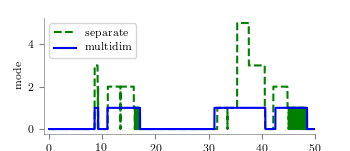

In [17]:
fig, ax = plt.subplots()
ax.plot(controllers["pinv"]["singular_res"]["t_sim"], controllers["pinv"]["singular_res"]["mode_sim"], 
        label="separate", ls="--", c="g")
ax.plot(controllers["pinv"]["multidim_res"]["t_sim"], controllers["pinv"]["multidim_res"]["mode_sim"],
       label="multidim", ls="-", c="b")
ax.legend()
ax.set_xlim([-1, 50])
ax.set_xlabel("t [s]")
ax.set_ylabel("mode")
nice_plotting.format_axes(ax)
plt.savefig("modes.pdf", bbox_inches="tight")
#ax.plot(controllers["pinv"]["singular_res"]["t_sim"], controllers["pinv"]["singular_res"]["mode_sim"],ls="--")

<IPython.core.display.Javascript object>


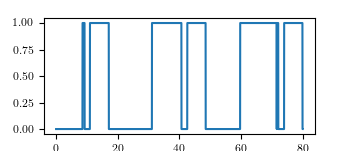

In [18]:
fig, ax = plt.subplots()
ax.plot(controllers["pinv"]["multidim_res"]["t_sim"], controllers["pinv"]["multidim_res"]["mode_sim"])
#ax.plot(controllers["pinv"]["singular_res"]["t_sim"], controllers["pinv"]["singular_res"]["mode_sim"],ls="--")

<IPython.core.display.Javascript object>


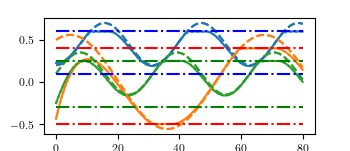

In [19]:
ax = common_plots.pos_point(controllers["pinv"]["multidim_res"], p_des=fpath_des)
ax = common_plots.pos_point(controllers["mpc"]["multidim_res"],ax=ax, lstyle=":", p_des=fpath_des)
ax.plot([min(t_sim), max(t_sim)], [x_min,x_min],"b-.")
ax.plot([min(t_sim), max(t_sim)], [x_max,x_max],"b-.")
ax.plot([min(t_sim), max(t_sim)], [y_min,y_min],"r-.")
ax.plot([min(t_sim), max(t_sim)], [y_max,y_max],"r-.")
ax.plot([min(t_sim), max(t_sim)], [z_min,z_min],"g-.")
ax.plot([min(t_sim), max(t_sim)], [z_max,z_max],"g-.")


<IPython.core.display.Javascript object>


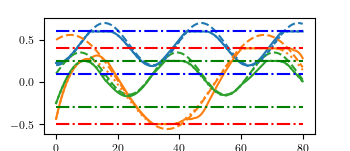

In [20]:
ax = common_plots.pos_point(controllers["pinv"]["singular_res"], p_des=fpath_des)
ax = common_plots.pos_point(controllers["qp"]["singular_res"], ax=ax, lstyle=":")
ax.plot([min(t_sim), max(t_sim)], [x_min,x_min],"b-.")
ax.plot([min(t_sim), max(t_sim)], [x_max,x_max],"b-.")
ax.plot([min(t_sim), max(t_sim)], [y_min,y_min],"r-.")
ax.plot([min(t_sim), max(t_sim)], [y_max,y_max],"r-.")
ax.plot([min(t_sim), max(t_sim)], [z_min,z_min],"g-.")
ax.plot([min(t_sim), max(t_sim)], [z_max,z_max],"g-.")

<IPython.core.display.Javascript object>


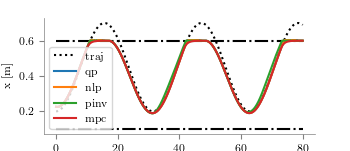

In [21]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
# Trajectory
ax.plot(
    controllers["pinv"]["singular_res"]["t_sim"],
    [fpath_des(ti)[0] for ti in controllers["pinv"]["singular_res"]["t_sim"]],
    ls=":", color="k", label="traj"
)
ax.plot([min(t_sim), max(t_sim)], [x_min,x_min],"k-.")
ax.plot([min(t_sim), max(t_sim)], [x_max,x_max],"k-.")
# Controllers
for i,key in enumerate(controllers):
    ax.plot(
        controllers[key]["singular_res"]["t_sim"],
        controllers[key]["singular_res"]["p_sim"][:,0],
        c=cmap(i), ls="-", label=key
    )
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("x [m]")
nice_plotting.format_axes(ax)
plt.savefig("singular_set_constraint_x.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


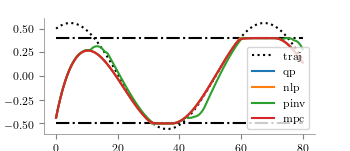

In [22]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
# Trajectory
ax.plot(
    controllers["pinv"]["singular_res"]["t_sim"],
    [fpath_des(ti)[1] for ti in controllers["pinv"]["singular_res"]["t_sim"]],
    ls=":", color="k", label="traj"
)
ax.plot([min(t_sim), max(t_sim)], [y_min,y_min],"k-.")
ax.plot([min(t_sim), max(t_sim)], [y_max,y_max],"k-.")
# Controllers
for i,key in enumerate(controllers):
    ax.plot(
        controllers[key]["singular_res"]["t_sim"],
        controllers[key]["singular_res"]["p_sim"][:,1],
        c=cmap(i), ls="-", label=key
    )
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("y [m]")
nice_plotting.format_axes(ax)
plt.savefig("singular_set_constraint_y.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


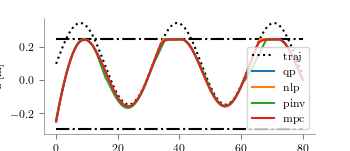

In [23]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
# Trajectory
ax.plot(
    controllers["pinv"]["singular_res"]["t_sim"],
    [fpath_des(ti)[2] for ti in controllers["pinv"]["singular_res"]["t_sim"]],
    ls=":", color="k", label="traj"
)
ax.plot([min(t_sim), max(t_sim)], [z_min,z_min],"k-.")
ax.plot([min(t_sim), max(t_sim)], [z_max,z_max],"k-.")
# Controllers
for i,key in enumerate(controllers):
    ax.plot(
        controllers[key]["singular_res"]["t_sim"],
        controllers[key]["singular_res"]["p_sim"][:,2],
        c=cmap(i), ls="-", label=key
    )
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("z [m]")
nice_plotting.format_axes(ax)
plt.savefig("singular_set_constraint_z.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


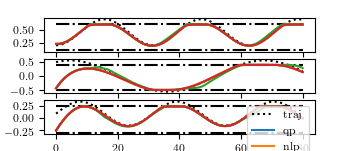

In [24]:
f, axs = plt.subplots(3,1)
cmap = plt.get_cmap("tab10")
axs[0].plot([min(t_sim), max(t_sim)], [x_min,x_min],"k-.")
axs[0].plot([min(t_sim), max(t_sim)], [x_max,x_max],"k-.")
axs[1].plot([min(t_sim), max(t_sim)], [y_min,y_min],"k-.")
axs[1].plot([min(t_sim), max(t_sim)], [y_max,y_max],"k-.")
axs[2].plot([min(t_sim), max(t_sim)], [z_min,z_min],"k-.")
axs[2].plot([min(t_sim), max(t_sim)], [z_max,z_max],"k-.")
for i, ax in enumerate(axs):
    ax.plot(controllers["pinv"]["singular_res"]["t_sim"],
           [fpath_des(ti)[i] for ti in controllers["pinv"]["singular_res"]["t_sim"]],
           ls=":", color="k", label="traj")
    for j, key in enumerate(controllers):
        ax.plot(
            controllers[key]["singular_res"]["t_sim"],
            controllers[key]["singular_res"]["p_sim"][:,i],c=cmap(j), ls="-", label=key
        )
ax.legend()

<IPython.core.display.Javascript object>


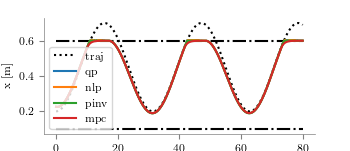

In [25]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
# Trajectory
ax.plot(
    controllers["pinv"]["multidim_res"]["t_sim"],
    [fpath_des(ti)[0] for ti in controllers["pinv"]["multidim_res"]["t_sim"]],
    ls=":", color="k", label="traj"
)
ax.plot([min(t_sim), max(t_sim)], [x_min,x_min],"k-.")
ax.plot([min(t_sim), max(t_sim)], [x_max,x_max],"k-.")
# Controllers
for i,key in enumerate(controllers):
    ax.plot(
        controllers[key]["multidim_res"]["t_sim"],
        controllers[key]["multidim_res"]["p_sim"][:,0],
        c=cmap(i), ls="-", label=key
    )
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("x [m]")
nice_plotting.format_axes(ax)
plt.savefig("multidim_set_constraint_x.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


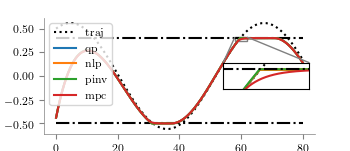

In [26]:
fig, ax = plt.subplots()
axins = zoomed_inset_axes(ax, 7, loc=7)
cmap = plt.get_cmap("tab10")
# Trajectory
ax.plot(
    controllers["pinv"]["multidim_res"]["t_sim"],
    [fpath_des(ti)[1] for ti in controllers["pinv"]["multidim_res"]["t_sim"]],
    ls=":", color="k", label="traj"
)
axins.plot(
    controllers["pinv"]["multidim_res"]["t_sim"],
    [fpath_des(ti)[1] for ti in controllers["pinv"]["multidim_res"]["t_sim"]],
    ls=":", color="k", label="traj"
)

ax.plot([min(t_sim), max(t_sim)], [y_min,y_min],"k-.")
ax.plot([min(t_sim), max(t_sim)], [y_max,y_max],"k-.")
# Controllers
for i,key in enumerate(controllers):
    ax.plot(
        controllers[key]["multidim_res"]["t_sim"],
        controllers[key]["multidim_res"]["p_sim"][:,1],
        c=cmap(i), ls="-", label=key
    )
    axins.plot(
        controllers[key]["multidim_res"]["t_sim"],
        controllers[key]["multidim_res"]["p_sim"][:,1],
        c=cmap(i), ls="-", label=key
    )
ax.legend(loc=2)
ax.set_xlabel("t [s]")
ax.set_ylabel("y [m]")
axins.set_xlim(58, 62)
axins.set_ylim(0.37,0.41)
axins.plot([min(t_sim), max(t_sim)], [y_max, y_max], "k-.")
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)

nice_plotting.format_axes(ax)
plt.savefig("multidim_set_constraint_y.pdf", bbox_inches="tight")

<IPython.core.display.Javascript object>


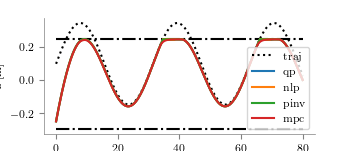

In [27]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
# Trajectory
ax.plot(
    controllers["pinv"]["multidim_res"]["t_sim"],
    [fpath_des(ti)[2] for ti in controllers["pinv"]["multidim_res"]["t_sim"]],
    ls=":", color="k", label="traj"
)
ax.plot([min(t_sim), max(t_sim)], [z_min,z_min],"k-.")
ax.plot([min(t_sim), max(t_sim)], [z_max,z_max],"k-.")
# Controllers
for i,key in enumerate(controllers):
    ax.plot(
        controllers[key]["multidim_res"]["t_sim"],
        controllers[key]["multidim_res"]["p_sim"][:,2],
        c=cmap(i), ls="-", label=key
    )
ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel("z [m]")
nice_plotting.format_axes(ax)
plt.savefig("multidim_set_constraint_z.pdf", bbox_inches="tight")#, pad_inches=200)

In [28]:
def ms_format(t):
    return"{:.2f} ms".format(1000.0*t)
cntrllrs_tab = ["pinv","qp","nlp","mpc"]
tab_str = "& PINV & QP & NLPC & MPC\\\\ \n\midrule\n"
tab_str += "Initial (separate)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(controllers[cntrl_key]["singular_res"]["t_run_sim"][0])
tab_str += "\\\\\n"
tab_str += "Average (separate)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(cs.np.mean(controllers[cntrl_key]["singular_res"]["t_run_sim"]))
tab_str += "\\\\\n"
tab_str += "Initial (multidim)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(controllers[cntrl_key]["multidim_res"]["t_run_sim"][0])
tab_str += "\\\\\n"
tab_str += "Average (multidim)"
for cntrl_key in cntrllrs_tab:
    tab_str += "& "+ms_format(cs.np.mean(controllers[cntrl_key]["multidim_res"]["t_run_sim"]))
print(tab_str)

& PINV & QP & NLPC & MPC\\ 
\midrule
Initial (separate)& 0.23 ms& 0.40 ms& 3.57 ms& 25.03 ms\\
Average (separate)& 0.22 ms& 0.21 ms& 3.26 ms& 35.79 ms\\
Initial (multidim)& 0.14 ms& 0.39 ms& 3.07 ms& 20.60 ms\\
Average (multidim)& 0.10 ms& 0.21 ms& 3.14 ms& 17.68 ms
